In [2]:
%matplotlib inline

In [3]:
from math import exp, log
import random
import seaborn as sns

# Module 12 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

# The Problem

When we last left our agent in Modules 1 and 11, it was wandering around a world filled with plains, forests, swamps, hills and mountains. This presupposes a map with known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it might it could see something like this:

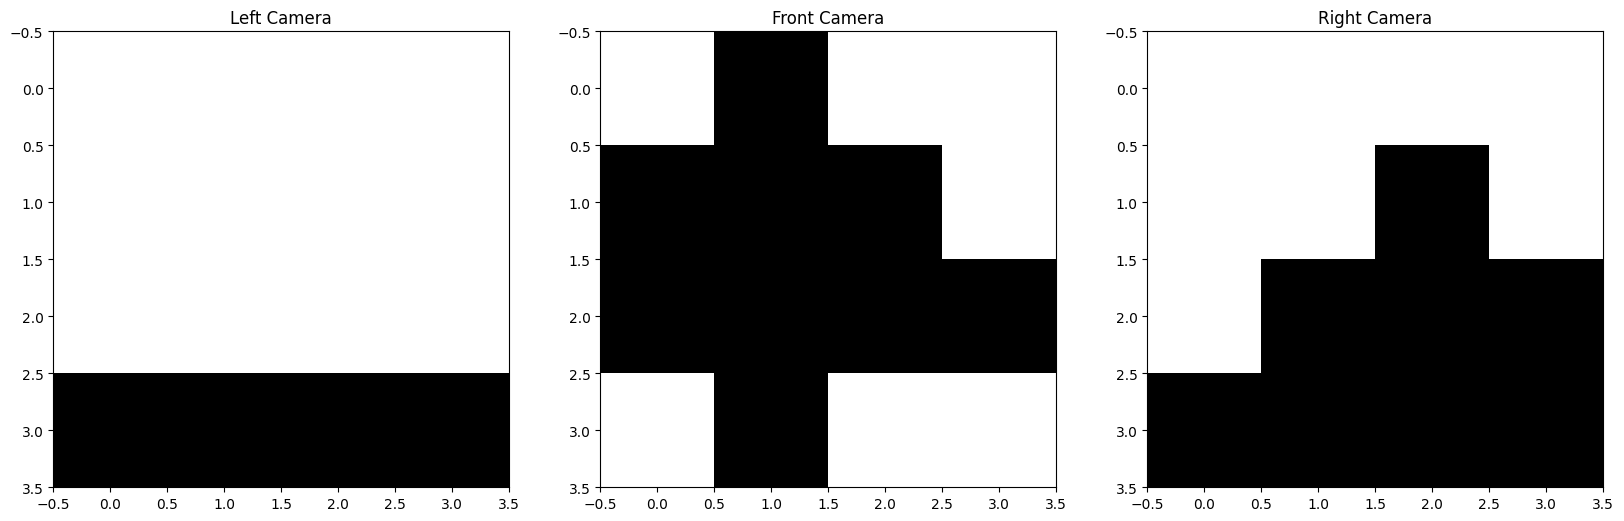

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

which would be plains, forest and hills respectively.

## The Assignment

For this programming assignment your tasks are:

1. Write a logistic regression that simply determines if something is a hill or not (two class problem). 
2. You will also evaluate that logistic regression by generating a *confusion matrix*.

For a starting point, refer to the Pseudocode and the Self-Check.

## Data

We have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often noisy.

Here are the clean examples with different registrations: 

In [5]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [6]:
def view_sensor_image(data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

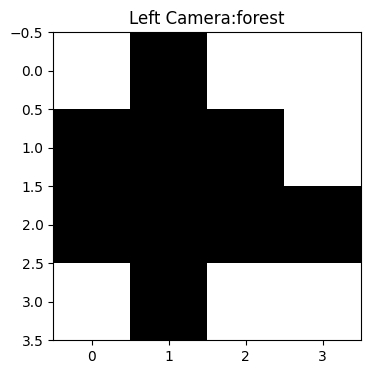

In [6]:
view_sensor_image( clean_data[ "forest"][0])

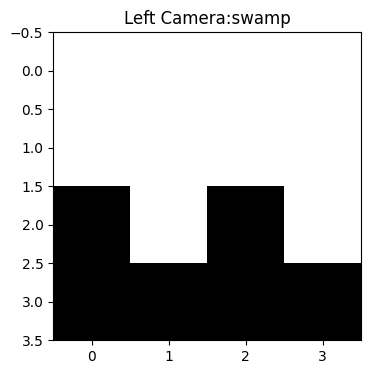

In [7]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

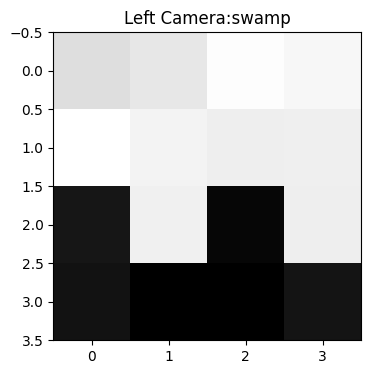

In [9]:
view_sensor_image( blur( clean_data["swamp"][0]))

We need four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`
4. `evaluate`

### generate_data

`generate_data` has been written for you.

* clean_data - the clean versions of the "bitmaps" for each of the terrain types
* n - the number of samples for "in the class" (1) and "not in the class" (0) to generate.
* label - the label to chose as "in the class".

For example,

`generate_data( clean_data, 100, "hills")`

generates 100 hills, 100 not hills and has transformed the String labels into 1 and 0, respectively.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the logistic regression model. If you're up to it, you can implement a vectorized version using Numpy but you might start with the loopy version first.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

I should also mention that gradient descent is not the usual approach to linear regression because the error function actually has an *exact* solution. However, in the case of large data sets, the exact solution often fails and in any case, the use of gradient descent will prepare you for neural networks next week.

When verbose is True, you should print out the error so you can see that it is getting smaller. 

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You'll have to experiment with both epsilon and alpha; and it doesn't hurt to make alpha adaptive (if the error increases, make alpha = alpha / 10).

When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the List of Thetas.

### `apply_model`

`apply_model` takes a List of Thetas (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a Tuple of the inferred value (0 or 1) and the actual probability (so something like (1, 0.73) or (0, 0.29). We always return the class with the higher probability.

If the data are labeled, you will return a Tuple of the actual value (0 or 1) and the predicted value (0 or 1). In this case, you return a List of something like [(0, 1), (1, 1), (0, 0), (1, 0)].

### `evaluate`

Ideally, we should be running 10 fold cross validation on this problem but...that might take a while so we're going to just go ahead with a simple evaluation. We're interested not only in the error rate but the overall "confusion" of the model.

The `evaluate` takes the results of `apply_model` when labeled=True and prints out the error rate and a confusion matrix.

---

Why `labeled=True` or `labeled=False`? While we only have labeled data right now, for model evaluation. In the future, you would need to use this function to do actual classification. In that case, `labeled=False`. Because in the long run, that's the default usage, we use `False` as the default.

---

**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you want.**

---

Put your helper functions above here.

## Main Functions

In [8]:
clean_data

{'plains': [[0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   'plains']],
 'forest': [[0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   'forest'],
  [0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   'forest'],
  [1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   'forest'],
  [0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   'forest']],
 'hills': [[0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   'hills'],
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   1.0,
   1.0,
   0.0,
   1.0,
   1.0,
   1.0

Use `generate_data` to generate a balanced set of blurred "hills" and "not-hills" examples to test that the function is working.

In [10]:
def generate_data( data, n, key_label):
    labels = list(data.keys())
    labels.remove(key_label)

    total_labels = len(labels)
    result = []
    # create n "not label" and code as y=0
    count = 1
    while count <= n:
        label = labels[count % total_labels]
        datum = blur(random.choice(data[label]))
        xs = datum[0:-1]
        result.append((xs, 0))
        count += 1

    # create n "label" and code as y=1
    for _ in range(n):
        datum = blur(random.choice(data[key_label]))
        xs = datum[0:-1]
        result.append((xs, 1))
    random.shuffle(result)
    return result

In [11]:
results = generate_data( clean_data, 10, "hills")
for result in results:
    print(result)

([0.10800599272746897, 0.10998703991633765, 0.059884234708493356, 0.13614719914178647, 0.0, 0.09478170919994389, 0.765017583831547, 0.13318178738414796, 0.18194990327771632, 0.957937333772565, 0.9373772360183404, 0.8618010386996912, 0.9677499845917351, 1.0, 0.8354107531016927, 0.7793789399085749], 1)
([0.08731270624392218, 0.01317211098738251, 0.08938305103449432, 0.07410039820916825, 0.15577171913887475, 0.11985095976466983, 0.08881395643219443, 0.758261593546532, 0.12416700198763714, 0.15545389934992776, 0.9528414561536669, 0.8107679048090077, 0.09373665407388651, 0.8619641829544773, 0.9376236282584943, 0.8335507452370721], 1)
([0.17640118367742813, 0.10319483308564616, 0.07290252579129958, 0.16109413985855164, 0.032856675371753186, 0.06366422422365584, 1.0, 0.1178601895898025, 0.13395418154191158, 1.0, 1.0, 0.8269338536278596, 1.0, 0.9356444619827444, 1.0, 0.957807444515139], 1)
([0.06270619951728104, 0.1788366863146661, 0.09706912674712018, 0.0496377670433965, 0.10126406457501373, 

<a id="linear"></a>
## linear

- Returns a list of linear predictions
- y-hat = theta0*x0 + theta1*x1 + .. + thetaN*xN

* **xs** list[list]: list of observations
* **thetas** list[floats]: list of thetas for each feature



**returns** List: list of predicted labels using a linear function

In [13]:
def linear(xs:list[list], thetas:list)->list:
    y_hat = []
    
    if len(xs[0]) != len(thetas):
        print("Something went wrong. Features vs thetas doesnt match")
    
    else:
        for x in xs:
            sm = 0
            for feature in range(len(x)):
                sm += x[feature] * thetas[feature]
            y_hat.append(sm)
    return y_hat


In [14]:
#verify empty list is returned if empty lists are passed
empty_check = linear([[]], [1.3,2.9])
assert empty_check == []

#verify number of observation and thetas returns an empty list
diff_size = linear([[1]], [1,2])
assert diff_size == []

#verify self check linear problems match
self_check_linear = linear([[1,1],[1,3]], [1.3,2.9])
assert self_check_linear == [4.2,10.0]

#verify 4 feature data works as expected
linear_4 = linear([[2,1,3],[4,2,10]], [2.0,3,1])
assert linear_4 == [2*2.0+1*3+3*1, 4*2.0+2*3+10]

Something went wrong. Features vs thetas doesnt match
Something went wrong. Features vs thetas doesnt match


<a id="sigmoid"></a>
## sigmoid

- Returns a predictions using sigmoid function
- y-hat = 1/ (1 + e(-1* linear_fnx))

* **theta_x** list: list of linear predictions

**returns** List: list of predicted labels using signmoid function

In [15]:
def sigmoid(theta_x:list)->list:
    sig= []
    for x in theta_x:
        sig.append(1/ (1 + exp(-x)))
    return sig

In [23]:
x = [1,2,3]

# verify empty theta_x returns an empty list
empty_theta = sigmoid([])
assert empty_theta == []

#verify self check question returns as expected
self_check_sig = sigmoid(linear([[1,1.1],[1,2.7]],[.8,1.1]))
assert round(self_check_sig[0],3) == .882
assert round(self_check_sig[1],3) == .977

#verify same number of observations is returned
obs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
ob_sig = sigmoid(obs)
assert len(ob_sig) == len(obs)

<a id="calculate_error"></a>
## calculate_error

- Calculates the error for logistic regression

* **y_hat** list: list of predicted values
* **y** list: list of actual values

**returns** float: error rate

In [18]:
def calculate_error(y_hat:list, y:list)->float:
    sm = 0

    #avoid division by zero
    if len(y) == 0:
        return 0;

    for i in range(len(y)):
 
        if y_hat[i] == 0:
            sm += y[i] * log(.00001) + (1-y[i]) * log(1-y_hat[i])
        
        elif 1 - y_hat[i] == 0:
            sm += y[i] * log(y_hat[i]) + (1-y[i]) * log(1-.00001)
       
        else:
            sm += y[i] * log(y_hat[i]) + (1-y[i]) * log(1-y_hat[i])
    error = - 1 / len(y) * sm

    return error

In [22]:
#verify empty data return 0
empty_loss = calculate_error([],[])
assert empty_loss == 0

#verify self returns the expected value
self_check_loss = calculate_error([.88,.97],[0,1])
assert round(self_check_loss,3) ==  1.075

#verify error is 0 if y_hat and y are the same
same_check = calculate_error([1,1,1],[1,1,1])
assert same_check == 0

#verify error not thrown if y_hat is zero
zero_check = calculate_error([0,1,1],[1,1,1])
assert round(zero_check,3) == 3.838

<a id="der_log"></a>
## der_log

- Takes the derivative of the logistic regression for a feature

* **y** list: list of actual values
* **x** list: all observations of one feature
* **y_hat** list: list of predicted values


**returns** float: the derivative of logistic regression of a feature

In [20]:
def der_log(y:list,x:list,y_hat:list)->float:
    sm = 0
    if len(y) == 0:
        return 0
    for i in range(len(y)):
        sm += (y_hat[i] - y[i]) * x[i]
    der = sm /len(y)

    return der

In [21]:
# verify empty data returns 0
zero_der = der_log([],[],[])
assert zero_der == 0

# verify self check returns as expected
self_check_der = der_log([0,1], [1,1],[.88,.97])
assert round(self_check_der,3) == round((.88-0 + .97-1) /2,3)


#verify self check value 2 returns as expected
self_check_der = der_log([0,1], [1.1,2.7],[.88,.97])
assert round(self_check_der,3) == round(((.88-0)*1.1 + (.97-1)*2.7) /2,3)

<a id="update_thetas"></a>
## update_thetas

- updates each theta to a new value
- This is from = thetas[ j] – alpha * derivative( j, thetas, data) 

* **thetas** list[floats]: list of thetas for each feature
* **obs** list[list]: list of observations
* **y** list: list of actual values
* **y_hat** list: list of predicted values
* **alpha** float: alpha value/learning rate


**returns** List: list new thetas

In [24]:
def update_thetas(thetas:list, obs:list[list], y:list, y_hat:list, alpha:float)->list:
    new_thetas = []
    for j in range(len(thetas)):
        x_j = [o[j] for o in obs]
        new_thetas.append(thetas[j] - alpha * der_log(y,x_j,y_hat))

    return new_thetas

In [25]:
# self check questions
self_thetas = [.8,1.1]
self_obs = [[1,1.1],[1,2.7]]
self_y = [0,1]
self_y_hat =[.88,.97]

new_thetas = update_thetas(self_thetas, self_obs, self_y, self_y_hat, .1)

# verify the new thetas is the same size
assert len(new_thetas) == len(self_thetas)

#verify original thetas is not changed
assert new_thetas != self_thetas

# verify the new thetas are the correct values
assert round(new_thetas[0],3) == .758
assert round(new_thetas[1],3) == 1.056

<a id="update_alpha"></a>
## update_alpha

- Updates alpha to be a smaller value if the error rate is increasing
- Otherwise, alpha remains the same

* **alpha** float: alpha value/learning rate
* **current_error** float: current error rate
* **prev_error** float: previous error rate


**returns** float: new alpha value

In [26]:
def update_alpha(alpha:float, current_error:float, prev_error:float)->float:

    if current_error > prev_error: # error increasing
        return alpha /10 # reduce alpha
    else:
        return alpha 

In [27]:
# verify alpha is reduced if error increases
assert update_alpha(.1, .05, .001) == .1/10

#verify alpha remains the same if error is the same
assert update_alpha(.1, .001, .001) == .1

#verify alpha remians the same if error decreases
assert update_alpha(.1, .0001, .001) == .1

<a id="learn_model"></a>
## learn_model

- Performs logistic regression
- returns a model which is a list of weights 

* **data** list[Tuple[obs, label]]: list of observations with its label
* **verbose** boolean: for debugging. Prints the error rate when set to true

**returns** List: list of weights/thetas

In [28]:
def learn_model(data:list, verbose=False)->list:
    y = [row[1] for row in data]
    obs = [[1] + row[0] for row in data] # add bias/theta0 feature
    thetas = [random.random() for f in obs[0]]
    prev_error = 0
    current_error = 1
    alpha = .01
    i = 0

    while (abs(current_error - prev_error) > .00000001):
        y_hat = sigmoid(linear(obs, thetas))
        new_thetas = update_thetas(thetas, obs, y, y_hat, alpha)
        thetas = new_thetas
        prev_error = current_error
        current_error = calculate_error(y_hat, y)
        alpha = update_alpha(alpha, current_error, prev_error)
        if verbose == True and i % 1000 == 0:
            print(i,"Iteration error rate:", current_error)
        i += 1
    return thetas

In [29]:
self_check_data = [[[1.1],0]
                   ,[[2.7],1]]
#self_theta_result = learn_model(self_check_data, True)
self_theta_result = learn_model(self_check_data, False)

#verify a list of size 2 is returned
assert len(self_theta_result) == 2

#verify the two thetas are different
assert self_theta_result[0] != self_theta_result[1]

#verify both values are floats
assert isinstance(self_theta_result[0], float)
assert isinstance(self_theta_result[1], float)


<a id="apply_model"></a>
## apply_model

- Makes predictions based on the model
- If labeled is true then a list of tuples is returned with y, y_hat
- If labeled is false then prediction and prediction probability is returned

* **model** list[floats]: list of thetas for each feature
* **test_data** list[list]: list of test data
* **labeled** boolean: indicator is data is labeled or not

**returns** List: list of predictions

In [30]:
def apply_model(model:list, test_data:list, labeled=False)->list:
    if labeled:
        y = [row[1] for row in test_data]
        obs = [[1] + row[0] for row in test_data]
    else:
        obs = [[1] + row for row in test_data] 
    
    y_hat_prob = sigmoid(linear(obs,model))
    y_hat = []
    
    for i in range(len(y_hat_prob)):
        if y_hat_prob[i] > .5: 
            y_hat.append(1)
        else:
            y_hat.append(0)
    if labeled:
        return [(y[row],y_hat[row]) for row in range(len(y))]
    else:
        return [(y_hat[row],y_hat_prob[row]) for row in range(len(y_hat))]      

In [31]:
# label check
apply_result_labels = apply_model([.8,1.1], self_check_data, True)
for row_i in range(len(apply_result_labels)):
    #verify first value is the actual label
    assert apply_result_labels[row_i][0] == self_check_data[row_i][1]

    #verify second value is a prediction not a prob
    assert apply_result_labels[row_i][1] in [0,1]
# unlabeled check
apply_result_unlabels = apply_model([.8,1.1,1],[[1,2],[1,3]], False)
for row_i in range(len(apply_result_unlabels)):
    #verify first value is the prediction
    assert apply_result_unlabels[row_i][0] in [0,1]

    #verify second value is a prob
    assert isinstance(apply_result_unlabels[row_i][1], float)

<a id="plot_confusion_matrix"></a>
## plot_confusion_matrix

- Plots the confusion matrix
- Should be in order of 
    - TP FP
    - FN TN

* **values** list: list of TP, FP, FN,TN

In [32]:
def plot_confusion_matrix(values:list):
    ax = sns.heatmap(values, annot=True)
    plt.yticks([1.5, 0.5], ['Not Hills','Hills']) # center label
    plt.xticks([1.5, 0.5], ['Not Hills','Hills']) #center label

    ax.set(xlabel='Actual', ylabel='Predictions')
    plt.show()


<a id="evaluate"></a>
## evaluate

- Prints the error rate and the confusion matrix

* **results** list: list actual and predicted values

In [33]:
def evaluate(results:list):
    y_hat = [row[1] for row in results]
    y = [row[0] for row in results]
    error_rate = calculate_error(y_hat, y)
    error_rate = error_rate * 100
    print("Error rate:", round(error_rate,3), "%")
    
    # true positives
    tp = fp =fn =tn = 0
    for i in range(len(y)):
        if y[i] ==y_hat[i]:# true value
            if y[i] == 0:
                tn += 1
            else:
                tp +=1
        elif y_hat[i] == 0: # false value, negative
            fn += 1
        else: # false positive
            fp += 1 
    plot_confusion_matrix([[tp,fp],[fn,tn]])

Error rate: 0.001 %


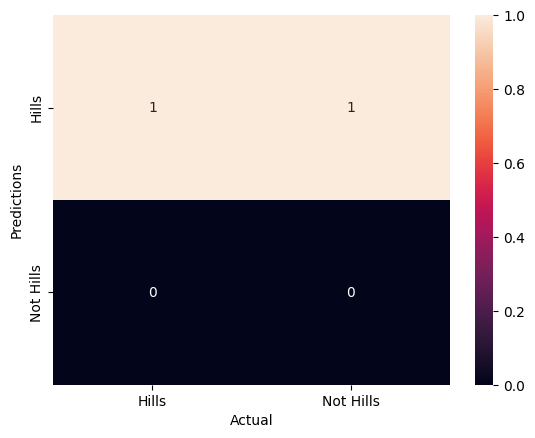

In [34]:
# no assert statements since this returns nothing
evaluate(apply_result_labels)

#visually verified error rate is printed
# verified chart is labeled with predictions and actual values
# in order
# TP FP
# FN TN

## Use your code

Use `generate_data` to generate 100 blurred "hills" examples balanced with 100 "non hills" examples and use this as your test data. Set labeled=True. Print out the first 10 results, one per line.

In [35]:
train_data = generate_data(clean_data, 100, "hills")

In [36]:
test_data = generate_data(clean_data, 100, "hills")

Use `learn_model` to learn a logistic regression model for classifying sensor images as "hills" or "not hills". Use your `generate_data` function to generate a training set of size 100 for "hills". **Set Verbose to True**

##  This took 45 minutes to run....

In [37]:
model = learn_model( train_data, True)

0 Iteration error rate: 1.92122983911934
1000 Iteration error rate: 1.10621458736019
2000 Iteration error rate: 0.7603019599843032
3000 Iteration error rate: 0.692996384670217
4000 Iteration error rate: 0.6776256459324362
5000 Iteration error rate: 0.6685655754442881
6000 Iteration error rate: 0.6604630374080231
7000 Iteration error rate: 0.6527280647514857
8000 Iteration error rate: 0.6452757324209338
9000 Iteration error rate: 0.6380764362262062
10000 Iteration error rate: 0.6311090865333345
11000 Iteration error rate: 0.6243558880222613
12000 Iteration error rate: 0.6178014385743046
13000 Iteration error rate: 0.6114323220871186
14000 Iteration error rate: 0.6052367974781498
15000 Iteration error rate: 0.599204537872641
16000 Iteration error rate: 0.5933264103722288
17000 Iteration error rate: 0.5875942907703864
18000 Iteration error rate: 0.5820009082965744
19000 Iteration error rate: 0.5765397159374474
20000 Iteration error rate: 0.5712047823700879
21000 Iteration error rate: 0.56

Apply the model to the test data:

In [38]:
results = apply_model( model, test_data, True)

Using the results above, print out your error rate (as a percent) and the confusion matrix:

Error rate: 0.0 %


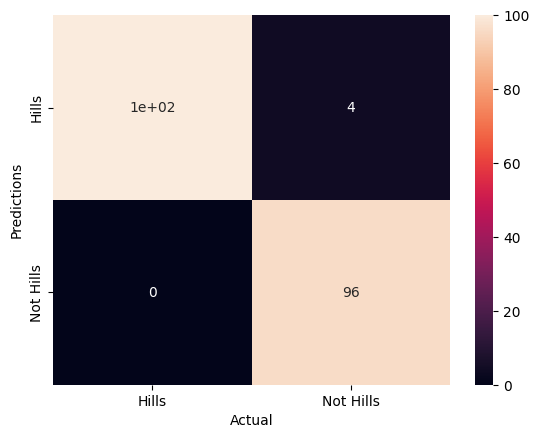

In [39]:
evaluate(results)

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.